In [ ]:
#necessary imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data
dcm_data = np.load('/content/drive/MyDrive/Colab Notebooks/dcm_data.npy')
label_data = np.load('/content/drive/MyDrive/Colab Notebooks/label_data.npy')

<function matplotlib.pyplot.show>

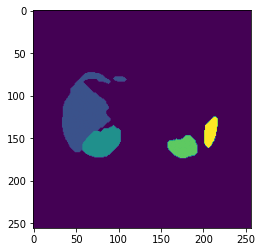

In [ ]:
img = label_data[20]
plt.imshow(img)
plt.show

In [ ]:
def liver(label_image):
    label_image = label_image/63
    label_image[label_image!=1] = 0
    return label_image

In [ ]:
def reshape(X):
    X = X.reshape(list(X.shape) + [1]) 
    return X

In [ ]:
x_data = dcm_data/255
y_data = liver(label_data)
print(x_data.shape, y_data.shape)

(623, 256, 256) (623, 256, 256)


In [ ]:
x_train = tf.cast(x_data, np.float32)
y_train = tf.cast(y_data, np.uint8)
x_train = x_train[..., None]
y_train = y_train[..., None]
print(x_train.shape, y_train.shape)

(623, 256, 256, 1) (623, 256, 256, 1)


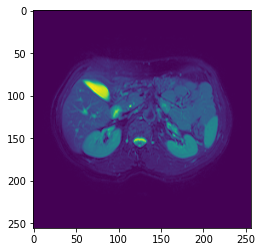

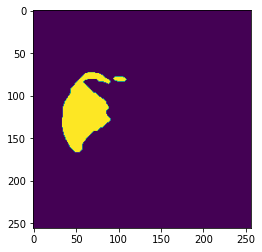

In [ ]:
#Check to make sure data has loaded in correctly
train_data_plot = tf.squeeze(x_train[20])
plt.imshow(train_data_plot)

plt.show()

train_label_plot = tf.squeeze(y_train[20])
plt.imshow(train_label_plot)

plt.show()

In [ ]:
xtrain = x_train[0:498,:,:,:]
xtest = x_train[498:623,:,:,:]
ytrain = y_train[0:498,:,:,:]
ytest = y_train[498:623,:,:,:] 

In [ ]:
class UNet(tf.keras.models.Model):
  def __init__(self):
    super().__init__()

    self.layer1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu')
    self.layer2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.layer3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')
    self.layer4 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
    self.layer5 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')
    self.layer6 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool3 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))
    self.layer7 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')
    self.layer8 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool4 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))
    self.layer9 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')
    self.layer10 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')
    self.transposeconv1 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size = 3, strides=2, padding='same', activation = 'relu')
    self.dropout1 = tf.keras.layers.Dropout(0.1) 
    self.layer11 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')
    self.layer12 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')
    self.transposeconv2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size = 3, strides=2, padding='same', activation = 'relu')
    self.dropout2 = tf.keras.layers.Dropout(0.1)
    self.layer13 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')
    self.layer14 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')
    self.transposeconv3 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size = 3, strides=2, padding='same', activation = 'relu')
    self.dropout3 = tf.keras.layers.Dropout(0.1)
    self.layer15 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')
    self.layer16 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')
    self.transposeconv4 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation = 'relu')
    self.dropout4 = tf.keras.layers.Dropout(0.1)
    self.layer17 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu')
    self.layer18 = tf.keras.layers.Conv2D(filters=16,kernel_size=3, strides=1, padding='same', activation='relu') 
    self.layer19 = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='same', activation='sigmoid')#changed from linear to sigmoid 
  
  def call(self, input):  
    x1 = self.layer1(input)
    x2 = self.layer2(x1)
    p1 = self.pool1(x2)
    x3 = self.layer3(p1)
    x4 = self.layer4(x3)
    p2 = self.pool2(x4)
    x5 = self.layer5(p2)
    x6 = self.layer6(x5)
    p3 = self.pool3(x6)
    x7 = self.layer7(p3)
    x8 = self.layer8(x7)
    p4 = self.pool4(x8)
    x9 = self.layer9(p4)
    x10 = self.layer10(x9)
    t1 = self.transposeconv1(x10)
    s1 = tf.keras.layers.Concatenate(axis=-1)([t1, x8])
    d1 = self.dropout1(s1)
    x11 = self.layer11(d1)
    x12 = self.layer12(x11)
    t2 = self.transposeconv2(x12)
    s2 = tf.keras.layers.Concatenate(axis=-1)([t2, x6]) 
    d2 = self.dropout2(s2)
    x13 = self.layer13(d2)
    x14 = self.layer14(x13)
    t3 = self.transposeconv3(x14)
    s3 = tf.keras.layers.Concatenate(axis=-1)([t3, x4])
    d3 = self.dropout3(s3)
    x15 = self.layer15(d3)
    x16 = self.layer16(x15)
    t4 = self.transposeconv4(x16)
    s4 = tf.keras.layers.Concatenate(axis=-1)([t4, x2])
    d4 = self.dropout4(s4)
    x17 = self.layer17(d4)
    x18 = self.layer18(x17)
    x19 = self.layer19(x18)

    return self.layer19(x18)

model = UNet()


In [ ]:
def dice_metric(y_true, y_pred):


    threshold = 0.5

    mask = y_pred > threshold
    mask = tf.cast(mask, dtype=tf.float32)
    y_pred = tf.multiply(y_pred, mask)
    mask = y_true > threshold
    mask = tf.cast(mask, dtype=tf.float32)
    y_true = tf.multiply(y_true, mask)

    inse = tf.reduce_sum(tf.multiply(y_pred, y_true))
    l = tf.reduce_sum(y_pred)
    r = tf.reduce_sum(y_true)

    hard_dice = (2. * inse) / (l + r)
    mean_dice = tf.reduce_mean(hard_dice)
    #tf.debugging.check_numerics(mean_dice, 'NaN found', name=None)
    value_not_nan = tf.dtypes.cast(tf.math.logical_not(tf.math.is_nan(mean_dice)), dtype=tf.float32)
    mean_dice_no_nan = tf.math.multiply_no_nan(mean_dice, value_not_nan)
    return mean_dice_no_nan

In [ ]:
model.compile(optimizer='adam',  # Optimizer
              loss='binary_crossentropy',  # Loss
                      metrics=[dice_metric])  # Metric to monitor

In [ ]:
history = model.fit(
    xtrain, ytrain,
    validation_split = 0.2,
    batch_size=16,
    epochs=50)

Epoch 1/50
25/25 [==============================] - 22s 314ms/step - loss: 0.5297 - dice_metric: 0.0106 - val_loss: 0.3885 - val_dice_metric: 0.0000e+00
Epoch 2/50
25/25 [==============================] - 4s 164ms/step - loss: 0.1831 - dice_metric: 0.0000e+00 - val_loss: 0.0789 - val_dice_metric: 0.0000e+00
Epoch 3/50
25/25 [==============================] - 4s 165ms/step - loss: 0.1064 - dice_metric: 0.0000e+00 - val_loss: 0.0778 - val_dice_metric: 0.0000e+00
Epoch 4/50
25/25 [==============================] - 4s 165ms/step - loss: 0.0915 - dice_metric: 0.0000e+00 - val_loss: 0.0653 - val_dice_metric: 0.0000e+00
Epoch 5/50
25/25 [==============================] - 4s 166ms/step - loss: 0.0813 - dice_metric: 0.0000e+00 - val_loss: 0.0668 - val_dice_metric: 0.0000e+00
Epoch 6/50
25/25 [==============================] - 4s 165ms/step - loss: 0.0740 - dice_metric: 0.0042 - val_loss: 0.0575 - val_dice_metric: 0.0320
Epoch 7/50
25/25 [==============================] - 4s 166ms/step - loss: 0

In [ ]:
def display_learning_curves(history):
    #acc = history.history['acc']
    #val_acc = history.history['val_accuracy']
    acc = history.history['dice_metric']
    val_acc = history.history['val_dice_metric']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(50)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

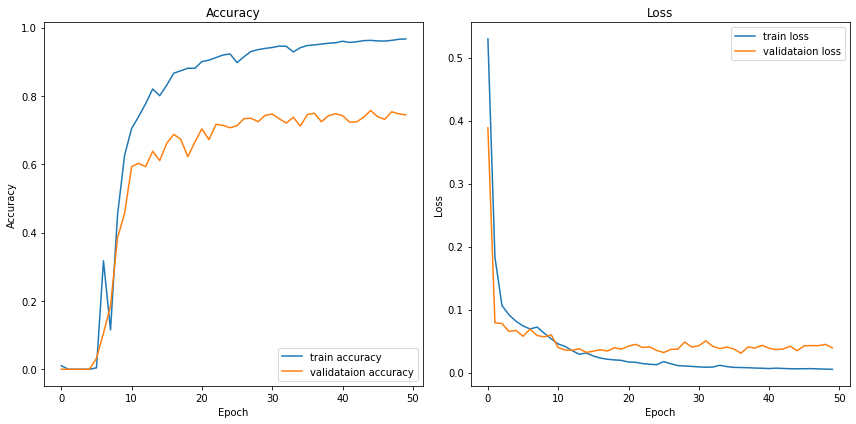

In [ ]:
# Display learning curves 
display_learning_curves(model.history)

In [ ]:
# Predict on training images
preds_train = model.predict(xtest, verbose=1)

4/4 [==============================] - 0s 114ms/step


In [ ]:
preds_train.shape

(125, 256, 256, 1)

In [ ]:
mask = np.zeros(preds_train.shape)
thred = 0.5
mask[preds_train>thred] = 1
mask[preds_train<thred] = 0

In [ ]:
def plot_sample(x, y, mask,preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(x[ix, ..., 0], cmap='gray')
    ax[0].set_title('Original Image')

    ax[1].imshow(tf.squeeze(y)[ix])
    ax[1].set_title('Ground Truth Mask')

    ax[2].imshow(tf.squeeze(mask[ix]))
    ax[2].set_title('UNet Predicted Mask')

    ax[3].imshow(tf.squeeze(preds[ix]))
    ax[3].set_title('UNet Predicted Result')

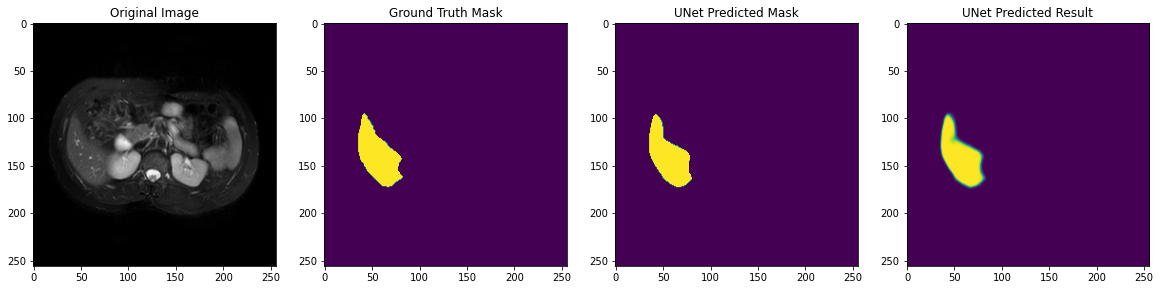

In [ ]:
# Look at data and output
plot_sample(xtest, ytest, mask , preds_train, ix=20)

In [ ]:
def count(pred,label):
  shape = pred.shape
  tpcount = 0
  tncount = 0
  fncount = 0
  fpcount = 0
  for i in range (0,shape[0]):
    for j in range (0,shape[1]):
      for k in range (0,shape[2]):
        if pred[i,j,k]==label[i,j,k] and label[i,j,k] ==0:
          tncount = tncount +1
        if pred[i,j,k]==label[i,j,k] and label[i,j,k] !=0:
          tpcount = tpcount+1
        if pred[i,j,k]!=label[i,j,k] and label[i,j,k] ==0:
          fncount = fncount+1
        if pred[i,j,k]!=label[i,j,k] and label[i,j,k] !=0:
          fpcount = fpcount+1
  return tncount,tpcount,fncount,fpcount

In [ ]:
def summask(l):
  summask = np.zeros(l.shape)
  summask[l!=0] = 63
  return summask
def sepemask(l):
  sepm = np.zeros(l.shape)
  sepm[l!=0] = 63
  return sepm
summask = summask(mask)
sepm = sepemask(y_data[498:623,:,:] )

In [ ]:
sepm.shape

(125, 256, 256)

In [ ]:
#np.set_printoptions(threshold=np.inf)
print(mask[20,1,1])
print(sepm[20,1,1])

[0.]
0.0


In [ ]:
[tn,tp,fn,fp] = count(mask,sepm)

In [ ]:
print(tn,tp,fn,fp)

7853912 0 16740 321348


In [ ]:
pa = (tn+tp)/mask.size
cpa = tp/(tp+fp)
IoU = tp/(tp+fn+fp)
dice = 2*tp/(2*tp+fn+fp)

In [ ]:
#print(res_accuracy,res_precision,res_recal,res_f1)
print(pa,cpa,IoU,dice)

0.9587294921875 0.0 0.0 0.0
